<a href="https://colab.research.google.com/github/pbr142/vae/blob/main/VAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for CIFAR10

## Notebook settings

In [1]:
COLAB = True # Flag to control Colab specific settings
FINAL = True # Flag to control final execution or faster development runs
n_train = 1000 # Number of training instances to use when FINAL is False
n_test = 100 # Number of test instances to sue when FINAL is False

## Imports

In [2]:
from tensorflow import keras
import tensorflow as tf

In [3]:
if FINAL:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')

## Load data

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
if not FINAL:
    X_train = X_train[:n_train]
    y_train = y_train[:n_train]
    X_test = X_test[:n_test]
    y_test = y_test[:n_test]

In [6]:
X_train.shape

(50000, 32, 32, 3)

## Build VAE model

In [60]:
dim_codings = 128

In [61]:
K = keras.backend

class Sampling(keras.layers.Layer):
    """ Given parameters (z_mean, z_log_var), samples a random realization of z as the encoding of the input"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=K.shape(z_mean))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [66]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
conv1 = keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
conv2 = keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(conv1)
conv3 = keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(conv2)
conv4 = keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(conv3)
flat = keras.layers.Flatten()(conv4)
dense = keras.layers.Dense(128, activation='relu')(flat)
z_mean = keras.layers.Dense(dim_codings)(dense)
z_log_var = keras.layers.Dense(dim_codings)(dense)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs=[inputs], outputs=[z_mean, z_log_var, z], name='encoder')

In [67]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 32)   896         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 4, 4, 128)    73856       conv2d_22[0][0]                  
____________________________________________________________________________________________

In [68]:
decoder_inputs = keras.layers.Input(shape=[dim_codings])
dedense = keras.layers.Dense(128, activation='relu')(decoder_inputs)
dedense2 = keras.layers.Dense(1024, activation='relu')(dedense)
reshape = keras.layers.Reshape(target_shape=[2,2,256])(dedense2)
deconv1 = keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation='relu')(reshape)
deconv2 = keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu')(deconv1)
deconv3 = keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu')(deconv2)
deconv4 = keras.layers.Conv2DTranspose(3, 3, 2, padding='same', activation='relu')(deconv3)
decoder = keras.Model(inputs=[decoder_inputs], outputs=[deconv4])

In [69]:
decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              132096    
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 4, 4, 128)         295040    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 32)        1846

In [70]:
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
vae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [71]:
vae.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 128), (None, 128) 552640    
_________________________________________________________________
model_5 (Functional)         (None, 32, 32, 3)         536771    
Total params: 1,089,411
Trainable params: 1,089,411
Non-trainable params: 0
_________________________________________________________________


In [72]:
latent_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(latent_loss) / 784.)

In [73]:
vae.compile(loss='binary_crossentropy', optimizer='NAdam', metrics=['mse'])

In [74]:
model_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Projects/VAE/vae_cifar10.ckpt', save_best_only=True)

In [ ]:
history = vae.fit(X_train, X_train, epochs=200, batch_size=256, validation_data=(X_test, X_test), callbacks=[model_cb])

Epoch 1/200
196/196 [==============================] - 11s 42ms/step - loss: 1.4260 - mse: 0.1391 - val_loss: 0.6650 - val_mse: 0.0462
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/VAE/vae_cifar10.ckpt/assets
Epoch 2/200
196/196 [==============================] - 8s 38ms/step - loss: 0.6670 - mse: 0.0477 - val_loss: 0.6609 - val_mse: 0.0431
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/VAE/vae_cifar10.ckpt/assets
Epoch 3/200
196/196 [==============================] - 7s 38ms/step - loss: 0.6602 - mse: 0.0438 - val_loss: 0.6718 - val_mse: 0.0457
Epoch 4/200
196/196 [==============================] - 7s 38ms/step - loss: 0.6872 - mse: 0.0505 - val_loss: 0.7919 - val_mse: 0.0525
Epoch 5/200
196/196 [==============================] - 7s 38ms/step - loss: 0.7346 - mse: 0.0451 - val_loss: 0.6667 - val_mse: 0.0386
Epoch 6/200
196/196 [==============================] - 7s 38ms/step - loss: 0.6649 - mse: 0.0413 - val_loss: 0.6585 - val_mse: 0.0431
INFO:

In [41]:
import pandas as pd

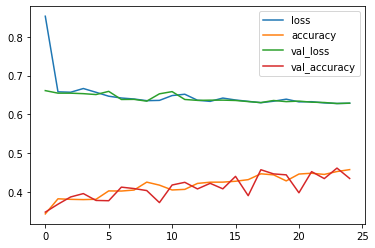

In [42]:
pd.DataFrame(history.history).plot()

In [ ]:
vae.save('my_model.h5') 

In [34]:
import matplotlib.pyplot as plt
import numpy as np

In [35]:
n_images = 5
images = X_test[:n_images]
reconstructed_images = vae.predict(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


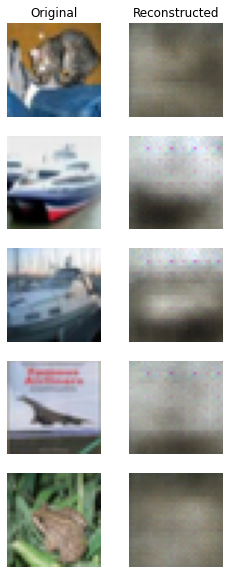

In [37]:
plt.figure(figsize=(4, n_images*2))
for i in range(n_images):
    plt.subplot(n_images, 2, i*2 + 1)
    plt.imshow(images[i])
    plt.axis('off')
    if i == 0:
        plt.title('Original')
    plt.subplot(n_images, 2, i*2+2)
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.show()

In [40]:
reconstructed_images.min()

0.10202238

In [35]:
vae = keras.modelas.Model(inputs=encoder, outputs=decoder)

ValueError: ignored

In [ ]:
latent_dimension = 32

In [ ]:
z_mean = keras.layers.Dense(latent_dimension, name='z_mean')(x.output)
z_log_var = keras.layers.Dense(latent_dimension, name='z_log_var')(x.output)
z = Sampling([z_mean, z_log_var])

In [ ]:
encoder = keras.Model([x.input], [z_mean, z_log_var], name='encoder')

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [ ]:
z.summary()

AttributeError: ignored